In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

clutter_data = pd.read_csv('../../data/clean/orbital_clutter_cleaned.csv')

print(f"Loaded {len(clutter_data)} objects.")
print(clutter_data['category'].value_counts())
clutter_data.head(10)

Loaded 32695 objects.
category
Debris                12662
Inactive Satellite    11978
Active Satellite       5610
Rocket Body            2397
Unknown                  48
Name: count, dtype: int64


,object_name,object_id,norad_id,object_type,ops_status,owner,launch_date,launch_site,decay_date,period_minutes,...,perigee_km,rcs,data_status,orbit_center,orbit_type,orbit_class,users,purpose,source,category
0,VANGUARD 1,1958-002B,5,PAY,NaN,US,1958-03-17,AFETR,NaN,132.60,...,651.0,0.1220,NaN,EA,ORB,MEO,NaN,NaN,left_only,Inactive Satellite
1,VANGUARD 2,1959-001A,11,PAY,NaN,US,1959-02-17,AFETR,NaN,120.99,...,552.0,0.3931,NaN,EA,ORB,LEO,NaN,NaN,left_only,Inactive Satellite
2,VANGUARD R/B,1959-001B,12,R/B,NaN,US,1959-02-17,AFETR,NaN,125.38,...,553.0,0.5266,NaN,EA,ORB,LEO,NaN,NaN,left_only,Rocket Body
3,VANGUARD R/B,1958-002A,16,R/B,NaN,US,1958-03-17,AFETR,NaN,137.20,...,651.0,0.2282,NaN,EA,ORB,MEO,NaN,NaN,left_only,Rocket Body
4,VANGUARD 3,1959-007A,20,PAY,NaN,US,1959-09-18,AFETR,NaN,123.95,...,506.0,0.6412,NaN,EA,ORB,LEO,NaN,NaN,left_only,Inactive Satellite
5,EXPLORER 7,1959-009A,22,PAY,NaN,US,1959-10-13,AFETR,NaN,94.45,...,434.0,0.5003,NaN,EA,ORB,LEO,NaN,NaN,left_only,Inactive Satellite
6,PIONEER 5,1960-001A,27,PAY,NaN,US,1960-03-11,AFETR,NaN,NaN,...,NaN,0.0008,NEA,SU,ORB,Unknown,NaN,NaN,left_only,Inactive Satellite
7,TIROS 1,1960-002B,29,PAY,-,US,1960-04-01,AFETR,NaN,97.40,...,618.0,0.8030,NaN,EA,ORB,LEO,NaN,NaN,left_only,Inactive Satellite
8,TRANSIT 2A,1960-007A,45,PAY,NaN,US,1960-06-22,AFETR,NaN,100.29,...,589.0,0.4299,NaN,EA,ORB,LEO,NaN,NaN,left_only,Inactive Satellite
9,SOLRAD 1 (GREB),1960-007B,46,PAY,NaN,US,1960-06-22,AFETR,NaN,99.00,...,576.0,0.3501,NaN,EA,ORB,LEO,NaN,NaN,left_only,Inactive Satellite


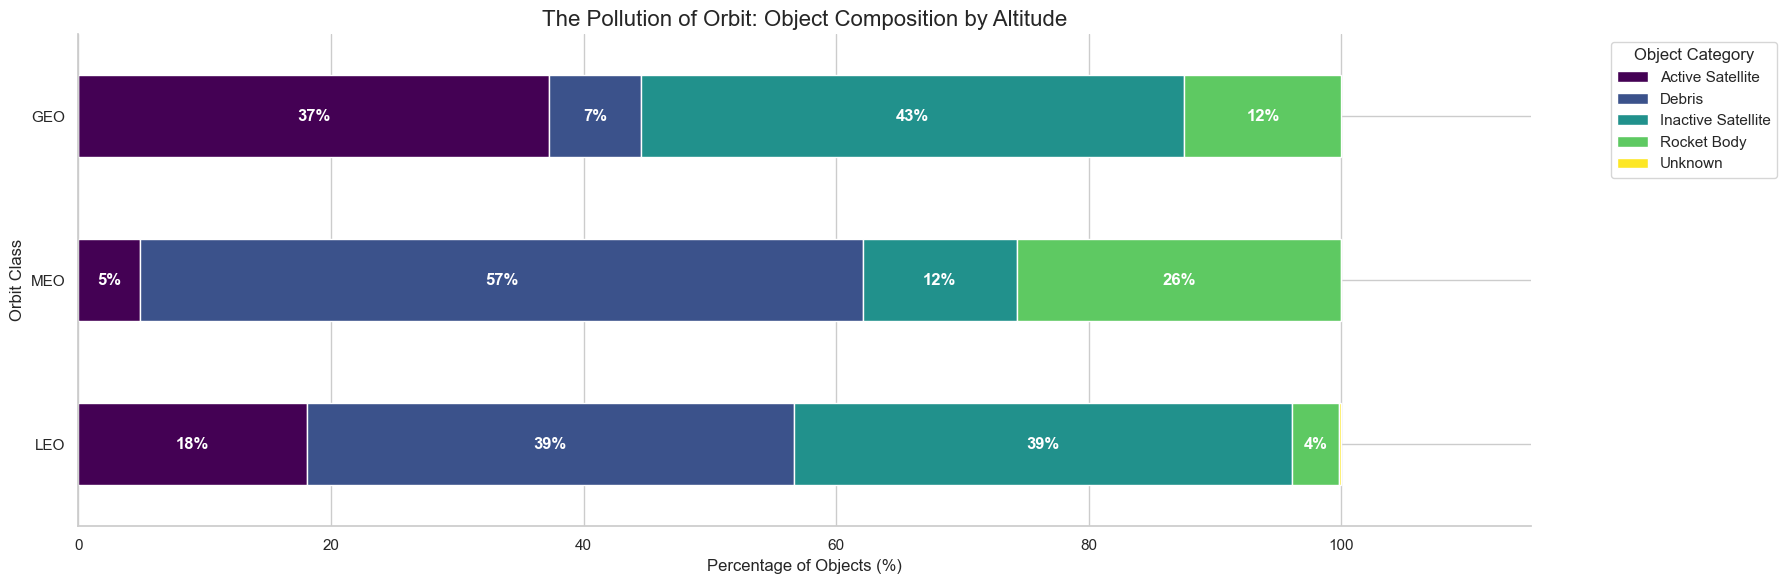

In [2]:
# Create the crosstab (Orbit Class vs Category)
orbit_composition = pd.crosstab(
    clutter_data['orbit_class'], 
    clutter_data['category'], 
    normalize='index'
) * 100 # Multiply by 100 to convert to percentage.

# Filter off elliptical and unknown orbits.
orbit_composition = orbit_composition.loc[['LEO', 'MEO', 'GEO']]

# Plot
ax = orbit_composition.plot(
    kind='barh', 
    stacked=True, 
    figsize=(18, 6), 
    colormap='viridis'
)

plt.title('The Pollution of Orbit: Object Composition by Altitude', fontsize=16)
plt.xlabel('Percentage of Objects (%)')
plt.ylabel('Orbit Class')

plt.legend(title='Object Category', bbox_to_anchor=(1.05, 1), loc='upper left')

for c in ax.containers:
    # Create custom labels: Only show text if the value is > 0 because the 0 is getting smashed at the end of the visualization.
    # v.get_width() gets the size of the bar segment
    labels = [f'{v.get_width():.0f}%' if v.get_width() > 1 else '' for v in c]
    
    # Apply the custom labels
    ax.bar_label(c, labels=labels, label_type='center', color='white', fontweight='bold')

plt.xlim(0, 115) # Extends the x-axis to 115% to make room for labels

sns.despine()
plt.tight_layout()
plt.show()